In [2]:
import csv
import json
import jsonpickle
from collections import Counter
from dataset_utils import DatasetEntry

In [20]:
import numpy as np

# Path to extension dataset
batch_path_ext = "batch_results/Batch_4278643_batch_results_ext.csv"
# Path to main dataset
batch_path_main = "batch_results/Batch_4265208_batch_results_main.csv"

csv_lines_main = []
with open(batch_path_main, "r") as csv_file:
    csv_reader = csv.reader(csv_file)
    csv_lines_main = list(csv_reader)

csv_lines_ext = []
with open(batch_path_ext, "r") as csv_file:
    csv_reader = csv.reader(csv_file)
    csv_lines_ext = list(csv_reader)
print(len(csv_lines_ext))

# Get all columns but leave out 'Approve' 'Reject' since they are not in the Data yet
columns_main = csv_lines_main[0][:-2]
data_lines_main = csv_lines_main[1:]

csv_entries_main = []
for line in data_lines_main:
    entry = dict()
    for idx, col in enumerate(columns_main):
        entry[col] = line[idx]
    csv_entries_main.append(entry)
    
# Get all columns but leave out 'Approve' 'Reject' since they are not in the Data yet
columns_ext = csv_lines_ext[0][:-2]
data_lines_ext = csv_lines_ext[1:]

csv_entries_ext = []
for line in data_lines_ext:
    entry = dict()
    for idx, col in enumerate(columns_ext):
        entry[col] = line[idx]
    csv_entries_ext.append(entry)
print(len(csv_entries_ext))
    
csv_entries = csv_entries_main + csv_entries_ext
print(len(csv_entries))

2521
2520
10809


Num Workers: 246
Mean of assignments one worker has done: 43.9390243902439
Median of assignments one worker has done: 4.0
Std Dev of assignments one worker has done: 169.06376149391943
Percent of workers did 10 or less: 0.6788617886178862
Percent of workers did only one task: 0.2926829268292683
Number of workers did only one task: 72


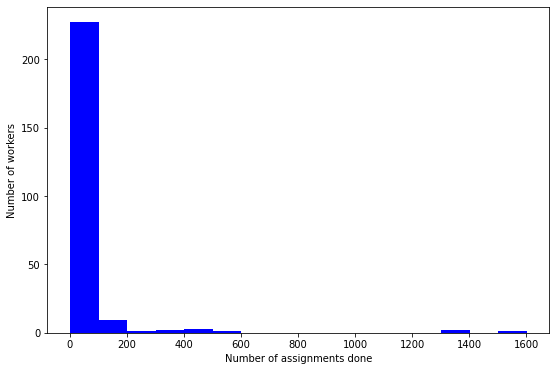

In [21]:
import numpy as np
worker_num_assignments = {}
# Retrieve worker ids from dataset
for entry in csv_entries:
    worker_id = entry['WorkerId']
    occurences = worker_num_assignments.get(worker_id, 0)
    occurences += 1
    worker_num_assignments[worker_id] = occurences

from statistics import median, mean, stdev

# Get only the number of assignments of individual workers
num_assignments = [worker_num_assignments[worker] for worker in worker_num_assignments.keys()]
# Sort them from low to high
num_assignments = sorted(num_assignments)

print("Num Workers: " + str(len(num_assignments)))
print("Mean of assignments one worker has done: " + str(mean(num_assignments)))
print("Median of assignments one worker has done: " + str(median(num_assignments)))
print("Std Dev of assignments one worker has done: " + str(stdev(num_assignments)))

print(f"Percent of workers did 10 or less: {num_assignments.index(11)/len(num_assignments)}")
print(f"Percent of workers did only one task: {num_assignments.index(2)/len(num_assignments)}")
print(f"Number of workers did only one task: {num_assignments.index(2)}")


# Plot histogram over num workers:
import matplotlib.pyplot as plt
binwidth = 100
plt.figure(figsize=(9,6))
plt.hist([num_assignments], color=['blue'], bins=np.arange(min(num_assignments), max(num_assignments) + binwidth, binwidth))
plt.xlabel("Number of assignments done")
plt.ylabel("Number of workers")
plt.show()



# Check poem answer distribution

In [22]:
from dataset_utils import DatasetEntry
import json
from collections import Counter

pair_ids = []
dataset_entries = {}
print(len(csv_entries))
for entry in csv_entries:
    # Get entry id
    pair_id = entry['Input.pair_id']
    # If entry is not yet in dict create it
    if pair_id not in dataset_entries.keys():
        pair_ids.append(pair_id)
        # Get poem details
        poem1 = entry['Input.poem1']
        poem2 = entry['Input.poem2']
        dataset1 = entry['Input.poem1_dataset']
        dataset2 = entry['Input.poem2_dataset']

        dataset_entries[pair_id] = DatasetEntry(pair_id, poem1, poem2, dataset1, dataset2)

    dataset_entry = dataset_entries[pair_id]
    submitted_values = json.loads(str(entry['Answer.taskAnswers']))[0]
    dataset_entry.update_values(submitted_values)   
    dataset_entries[pair_id] = dataset_entry


vote_ratios_in_each_cat = {}
votes_in_each_cat_1 = {}
votes_in_each_cat_2 = {}

for cat in ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking", "melodious"]:
    cat_entries = []
    for key in dataset_entries:
        cat_entries.extend(getattr(dataset_entries[key], cat))
    cat_counter = Counter(cat_entries)
    votes_1 = cat_counter['1']
    votes_2 = cat_counter['2']
    vote_ratios_in_each_cat[cat] = votes_1/(votes_1+votes_2)
    votes_in_each_cat_1[cat] = votes_1
    votes_in_each_cat_2[cat] = votes_2


print(vote_ratios_in_each_cat)
print(votes_in_each_cat_1)
print(votes_in_each_cat_2)

10809
{'coherent': 0.5461942257217848, 'grammatical': 0.5451443569553805, 'moved': 0.5601049868766405, 'real': 0.5653543307086614, 'rhyming': 0.5606299212598426, 'readable': 0.5514435695538058, 'comprehensible': 0.5585301837270341, 'intense': 0.5398950131233596, 'liking': 0.5627296587926509, 'melodious': 0.5380577427821522}
{'coherent': 2081, 'grammatical': 2077, 'moved': 2134, 'real': 2154, 'rhyming': 2136, 'readable': 2101, 'comprehensible': 2128, 'intense': 2057, 'liking': 2144, 'melodious': 2050}
{'coherent': 1729, 'grammatical': 1733, 'moved': 1676, 'real': 1656, 'rhyming': 1674, 'readable': 1709, 'comprehensible': 1682, 'intense': 1753, 'liking': 1666, 'melodious': 1760}


In [6]:
import json
from collections import Counter
# Create stats about worker preferences
vote_preference_per_worker = {}
for entry in csv_entries:
    worker_id = entry['WorkerId']
    worker_votes = vote_preference_per_worker.get(worker_id, [])
    votes = json.loads(entry['Answer.taskAnswers'])[0]
    for key in votes:
        if votes[key]['1']:
            worker_votes.append(1)
        elif votes[key]['2']:
            worker_votes.append(2)
        else:
            worker_votes.append(0)
    vote_preference_per_worker[worker_id] = worker_votes

def calc_worker_pref_ratio(vote_list):
    counter = Counter(vote_list)
    votes_1 = counter[1]
    votes_2 = counter[2]
    num_votes = votes_1 + votes_2
    if votes_1 == 0:
        ratio = 0.
    if votes_2 == 0:
        ratio = 1.
    else:
        ratio = votes_1 / (votes_1 + votes_2)
    return ratio, num_votes
    
vote_preference_per_worker = {worker_id: calc_worker_pref_ratio(vote_preference_per_worker[worker_id]) for worker_id in vote_preference_per_worker}
print(vote_preference_per_worker['A03922113RU44GENR8ATX'][1])
print(vote_preference_per_worker)

sus_workers = [(worker_id, vote_preference_per_worker[worker_id][0], vote_preference_per_worker[worker_id][1]) for worker_id in vote_preference_per_worker if not 0.4 < vote_preference_per_worker[worker_id][0] < 0.6 and vote_preference_per_worker[worker_id][1] > 20]
print([sus_w[0] for sus_w in sus_workers])
print(len(sus_workers))
print(sus_workers)

1359
{'A03922113RU44GENR8ATX': (0.5923473142016188, 1359), 'A33TFZWRGY3ASF': (0.46165338645418325, 2008), 'AXQWKUJF7SQXP': (0.5946, 5000), 'A382DQH5UWU7SG': (0.9, 20), 'AXFESYBQ21CVX': (0.5769230769230769, 26), 'AHAF93PYUCVQ1': (0.5470841842523259, 4407), 'A1KFK92GEFQ9F5': (0.550561797752809, 178), 'A2J65ZHAJQDKAC': (0.43243243243243246, 111), 'A3PBZQQIFK4MI8': (0.5714285714285714, 7), 'A1Z6F6EIUJFC6T': (0.5959147424511545, 1126), 'A299J4PKHAEU9H': (0.5815085158150851, 1233), 'A171VJ9J60DSJU': (0.3333333333333333, 9), 'A2O5PN17VNYXI0': (0.4122257053291536, 638), 'A1CF6U3GF7DZEJ': (0.7370892018779343, 426), 'AMG9Y1YLBTKIV': (0.5192307692307693, 468), 'A2KFBIPESKBKWK': (0.5384615384615384, 26), 'A3P7M9666KJCP': (0.6793893129770993, 131), 'A2ZBYVQLDUZOV7': (0.5333333333333333, 120), 'A681XM15AN28F': (0.847457627118644, 1652), 'A3PYEW6693PCHT': (0.5192307692307693, 52), 'A10NF5TK6IFNX6': (0.7448979591836735, 98), 'A3QZMGTVA4VO44': (0.4471422432316287, 4654), 'A2A2VSZ2C8PC19': (0.5384615384

In [9]:
# Check on individual workers
worktime_measures = []
last_submission_date = ""
first_submission_date = ""
for entry in csv_entries:
    if (entry['WorkerId'] == 'AXQWKUJF7SQXP'):
        worktime = int(entry['WorkTimeInSeconds'])
        worktime_measures.append(worktime)
        if worktime < 10:
            print(entry['Input.poem1'].replace("<br>", "\n"))
            print("=====")
            print(entry['Input.poem2'].replace("<br>", "\n"))
            print(entry['Answer.taskAnswers'])
            print()
            print()
            
        last_submission_date = entry['SubmitTime']
from statistics import mean
print(len(worktime_measures))
print(mean(worktime_measures))
print(last_submission_date)
        
        

0


StatisticsError: mean requires at least one data point

In [ ]:
batch_path = "batch_results/Batch_4265208_batch_results.csv"
with open(batch_path, "r") as f:
    lines = f.readlines()

num_to_reject = sum([w[2] for w in sus_workers])
print("Number of expected rejections: " + str(num_to_reject))
reject_workers = [w[0] for w in sus_workers]
reviewed_lines = []
rejections = 0
for idx, line in enumerate(lines):
    line = line.strip()
    if idx == 0:
        reviewed_lines.append(line)
        continue
    reject_line = False
    for worker in reject_workers:
        if worker in line:
            reject_line = True
            rejections += 1
            break
    if reject_line:
        line = line + ',"","Worker not trustworthy since one option was too many times preferred over another in a statistically very unlikely scenario"'
    else:
        line = line + ',"",""'
        
    reviewed_lines.append(line)

print(len(reviewed_lines))
print("Rejections: " + str(rejections))
with open("batch_results/Batch_4265208_batch_results_reviewed.csv", "w+") as f:
    for line in reviewed_lines:
        f.write(line + "\n")
        
            

In [11]:
# Get stats over consensus objects
final_dataset = []
for entry in dataset_entries:
    try:
        final_dataset.append(dataset_entries[entry].get_consensus())
    except:
        pass

print(final_dataset)
vote_ratios_in_each_cat = {}
for cat in ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking"]:
    cat_entries = []
    for elem in final_dataset:
        cat_entries.append(getattr(elem, cat))
    cat_counter = Counter(cat_entries)
    votes_1 = cat_counter['1']
    votes_2 = cat_counter['2']
    vote_ratios_in_each_cat[cat] = votes_1/(votes_1+votes_2)

print(vote_ratios_in_each_cat)
    



[]


ZeroDivisionError: division by zero

In [12]:
import csv
import random

from collections import Counter
from statistics import mean

# Get all poems with their respective data set
unique_poems = []
pairs = []
old_poems = []
for _, entry in dataset_entries.items():
    tuple1 = (entry.poem1, entry.dataset1)
    tuple2 = (entry.poem2, entry.dataset2)
    if tuple1 not in unique_poems:
        unique_poems.append(tuple1)
    if tuple2 not in unique_poems:
        unique_poems.append(tuple2)
    old_poems.extend([tuple1, tuple2]*3)
    pairs.append((tuple1, tuple2))


old_pairs = pairs
least_used_poems = list(set([poem for poem, count in Counter(old_poems).items() if count <= 3]))
unique_poems = least_used_poems
print(len(old_poems))

n = 200
chosen_poems = []
# Choose 50% real poems
temp_poems = []
chance_real = 0.245
chance_not_real = 1. - chance_real

num_real_poems = float(n) * chance_real
num_not_real_poems = float(n) * chance_not_real/6

print(f"Chances: Real({chance_real} - Not Real({chance_not_real})")
print(f"Num: Real({num_real_poems}) - Not Real({num_not_real_poems})")

while len(temp_poems) < num_real_poems:
    p = random.choice(unique_poems)
    if p not in temp_poems and p[1] == "gutenberg":
        temp_poems.append(p)
chosen_poems.extend(temp_poems)

for model in ['gpt2','lstm','ngram','hafez','deepspeare','jhamtani']:
    # Choose GPT-2 poems
    temp_poems = []
    while len(temp_poems) < num_not_real_poems:
        p = random.choice(unique_poems)
        if p not in temp_poems and p[1] == model:
            temp_poems.append(p)
    chosen_poems.extend(temp_poems)
print(len(unique_poems))
print(len(chosen_poems))

# Create pairs
pairs = []
leftover_poems = list(set(least_used_poems) - set(chosen_poems))
print(f"Num leftovers: {len(leftover_poems)}")
for poem in chosen_poems:
    # Choose 6 other poems differing from the current and not in the list
    for i in range(6):
        counter_part = random.choice(leftover_poems)
        while (poem, counter_part) in pairs + old_pairs or (counter_part, poem) in pairs + old_pairs:
            counter_part = random.choice(leftover_poems)
        pairs.append((poem, counter_part))

new_unique_poems = []
new_poems = []
num_real = 0
for pair in pairs:
    tuple1 = pair[0]
    tuple2 = pair[1]
    if tuple1[1] == "gutenberg" or tuple2[1] == "gutenberg":
        num_real += 1 
    # print(tuple2)
    new_poems.extend([tuple1, tuple2])
    if tuple1 not in new_unique_poems:
        new_unique_poems.append(tuple1)
    if tuple2 not in new_unique_poems:
        new_unique_poems.append(tuple2)


print(f"Num unique poems in batch: {len(new_unique_poems)}")
print(num_real)
print(pairs[:10])
print(len(pairs))
counter = Counter(new_poems)
counter.most_common(10)


print(len(old_poems))
old_new_poems = old_poems + new_poems
final_occurences = Counter(old_new_poems)
mean([count for _, count in final_occurences.items()])


# Check how many times each poem is compared to another one
old_pairs = set(old_pairs)
print(len(old_pairs))
new_pairs = set(pairs)
print(len(new_pairs))
comparison_poems = []
for pair in (old_pairs | new_pairs):
    comparison_poems.append(pair[0])
    comparison_poems.append(pair[1])
single_comparison_counter = Counter(comparison_poems)
mean([count for poem, count in single_comparison_counter.items()])
    






5100
Chances: Real(0.245 - Not Real(0.755)
Num: Real(49.0) - Not Real(25.166666666666668)
1321
205
Num leftovers: 1116
Num unique poems in batch: 956
670
[(('now hast thou passed from tears and pain away ,<br>thine ear hath caught the heavenly melodies ;—<br>so be it mine , with reverent touch , to-day ,<br>on thy fair head this diadem to lay ,<br>and crown thee queen immortal for the skies !', 'gutenberg'), ('silent labours of the rain<br>shall be near thee , reconciled ;<br>little lives of leaves and grain ,<br>all things shy and wild<br>tell thee secrets , quiet child .', 'gutenberg')), (('now hast thou passed from tears and pain away ,<br>thine ear hath caught the heavenly melodies ;—<br>so be it mine , with reverent touch , to-day ,<br>on thy fair head this diadem to lay ,<br>and crown thee queen immortal for the skies !', 'gutenberg'), ('the poignant misery of dawn begins to grow . . .<br>we only know war lasts , rain soaks , and clouds sag stormy .<br>dawn massing in the east he

2.790073775989269

{'lstm': 153, 'gutenberg': 526, 'true_poetry': 180, 'hafez': 159, 'jhamtani': 164, 'ngram': 202, 'gpt2': 153, 'deepspeare': 163}
['lstm', 'gutenberg', 'true_poetry', 'hafez', 'jhamtani', 'ngram', 'gpt2', 'deepspeare']
[153, 526, 180, 159, 164, 202, 153, 163]


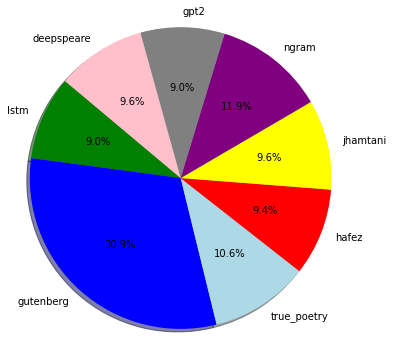

In [13]:
# Get Distribution of data sets
from collections import Counter

dataset_occs = []
for id, entry in dataset_entries.items():
    dataset_occs.extend([entry.dataset1, entry.dataset2])

dataset_count = dict(Counter(dataset_occs))
dataset_names = [k for k in dataset_count]
occs = [dataset_count[k] for k in dataset_names]
print(dataset_count)
print(dataset_names)
print(occs)

labels = dataset_names
sizes = occs
colors = ['green', 'blue', 'lightblue', 'red', 'yellow', 'purple', 'gray', 'pink']

# plot
plt.figure(figsize=(6,6))
plt.pie(sizes,              # data
        labels=labels,      # slice labels
        colors=colors,      # array of clors
        autopct='%1.1f%%',  # print the values inside the wedges
        shadow=True,        # enable shadow
        startangle=140)     # startin angle

plt.axis('equal')

plt.show()


In [12]:
votes_real_correct = 0
votes_real_false = 0
for key in dataset_entries:
    entry = dataset_entries[key]
    if entry.dataset1 == "gutenberg" and entry.dataset2 == "gutenberg":
        votes_real_correct += 1
        continue
    
    real = "1" if entry.dataset1 == "gutenberg" else "2"
    for vote in entry.real:
        if real == vote:
            votes_real_correct += 1
        else:
            votes_real_false += 1
    
print(votes_real_correct)
print(votes_real_false)
real_acc = float(votes_real_correct) / float(votes_real_correct + votes_real_false)
print(f"Accuracy of annotators choosing Real{real_acc}")
    

2048
1662
0.5520215633423181


coherent - coherent:			0.9999999999999998
coherent - grammatical:			0.1727303018921786
coherent - moved:			0.22184889380871112
coherent - real:			0.18417085888001283
coherent - rhyming:			0.1524120874499734
coherent - readable:			0.17219782033354103
coherent - comprehensible:			0.15007660323098537
coherent - intense:			0.045076633841554456
coherent - liking:			0.16365343477292313
coherent - melodious:			0.1576747695033598
grammatical - coherent:			0.1727303018921786
grammatical - grammatical:			1.0
grammatical - moved:			0.1972746551082316
grammatical - real:			0.16545405051024553
grammatical - rhyming:			0.2072103179822283
grammatical - readable:			0.20595365599807502
grammatical - comprehensible:			0.12139072642435447
grammatical - intense:			0.09659365192499861
grammatical - liking:			0.1798423947699173
grammatical - melodious:			0.15296775269944796
moved - coherent:			0.22184889380871112
moved - grammatical:			0.1972746551082316
moved - moved:			1.0
moved - real:			0.16552381995670

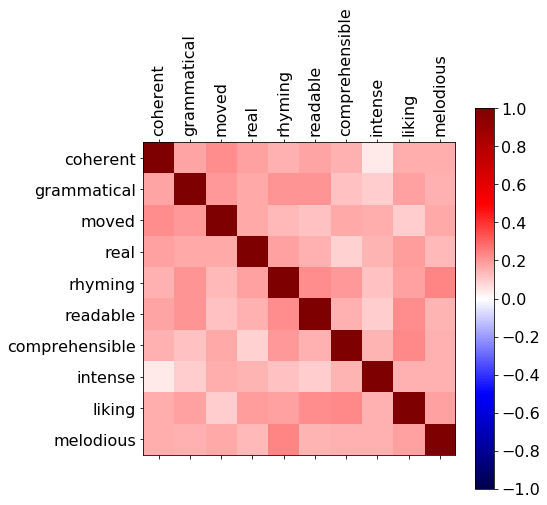

In [12]:
# Correlation analysis between features
from scipy import stats
from statistics import median

categories = ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking", "melodious"]

# dict mit cat als keys was als entry wieder alle categorien hat 

votes_per_cat = {}
for cat in categories:
    votes_per_cat[cat] = []
    for key in dataset_entries:
        votes = [int(v) for v in getattr(dataset_entries[key], cat)]
        if len(votes) > 1:
            vote = median(votes)
            votes_per_cat[cat].append(vote)

correlations = []
for i, cat1 in enumerate(categories):
    correlations.append([])
    for j, cat2 in enumerate(categories):
        corr = stats.pearsonr(votes_per_cat[cat1], votes_per_cat[cat2])[0]
        correlations[i].append(corr)
        print(f"{cat1} - {cat2}:\t\t\t{corr}")


import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(111)

cax = ax.matshow(correlations, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
fig.colorbar(cax, ticks=np.arange(-1, 1.2, 0.2))
xaxis = np.arange(len(categories))
print(xaxis)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)

ax.set_xticklabels(categories, rotation=90)
ax.set_yticklabels(categories)

plt.show()

#     entry = dataset_entries[key]
#     for cat in ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking", "melodious"]:
#         for cat in ["coherent", "grammatical", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking", "melodious"]
        

189.2392427659653
595


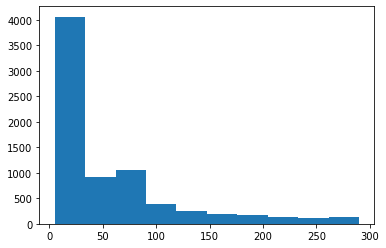

In [24]:
from statistics import mean, stdev
import matplotlib.pyplot as plt
assign_times = []
for ent in csv_entries:
    assign_times.append(int(ent['WorkTimeInSeconds']))

    
mean_time = mean(assign_times)
std_time = stdev(assign_times)
print(std_time)

cleaned_times = [t for t in assign_times if (abs(t - mean_time) < std_time)]

less_than_30 = len([t for t in assign_times if t < 10])
print(less_than_30)

plt.hist(cleaned_times)
plt.show()
